## Imports

In [4]:
import os
import cv2
import numpy as np
from random import randint
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import random
from sklearn.model_selection import train_test_split 
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


from keras.models import Model
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.layers import GlobalAveragePooling2D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection.iterative_stratification import IterativeStratification

2024-06-14 20:17:20.967795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Init feature exctractor

In [5]:
target_size = (224, 224)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*target_size, 3))
x = base_model.output  # 7*7*512
outputs = GlobalAveragePooling2D()(x)  # 1*1*512
model = Model(inputs=base_model.input, outputs=outputs)

## Data init

In [14]:
base_dir = '/Users/user/virtualenv/rosatom/'
folders = [
     'pascal_voc_rosatom'
]

### First stage detection

In [15]:
img_folder = 'JPEGImages'
ann_folder = 'Annotations'
img_ext = 'jpg'
sets_prefix = ''
labels = ['adj','int','geo','pro','non']
cluster_name = 'shvi_rosatom'
pca_apply = False

## Create train_val file

In [16]:
empty_xml = 0
for folder in folders:
    ann_dir = os.path.join(base_dir, folder, ann_folder)
    ann_filenames = sorted(glob.glob(ann_dir + '/*.xml'))
    print(folder, len(ann_filenames))
    
    trainval_txt = os.path.join(base_dir, folder, 'ImageSets', 'Main', f'{sets_prefix}trainval_20240614.txt')
    if os.path.exists(trainval_txt):
        os.remove(trainval_txt)
    with open(trainval_txt, 'w') as f:
        pass

    for filename in ann_filenames:
        
        tree = ET.parse(filename)
        root = tree.getroot()

        # empty xml
        if not root.findall('object'):
            empty_xml += 1
            print(filename)
            continue

        base_name = os.path.basename(filename)
        with open(trainval_txt, 'a') as f:
            f.write(base_name.rsplit('.', maxsplit=1)[0] + '\n')
    
    if empty_xml > 0:
        print(folder, f'empty xmls {empty_xml}')

pascal_voc_rosatom 1162
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/11_43_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/11_44_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/11_58_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_23_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_3_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_41_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_42_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_48_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_49_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_4_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_50_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_51_.xml
/Users/user/virtualenv/rosatom/pascal_voc_rosatom/Annotations/12_52_.xml
/Users/user/virtualenv/rosato

## Annotations (trainval.txt) with negative samples

In [17]:
import os
import glob
import xml.etree.ElementTree as ET

total_annotations = 0
for folder in folders:
    ann_dir = os.path.join(base_dir, folder, ann_folder)
    ann_filenames = sorted(glob.glob(ann_dir + '/*.xml'))
    print(folder, len(ann_filenames))
    
    trainval_txt = os.path.join(base_dir, folder, 'ImageSets', 'Main', f'{sets_prefix}trainval_20240614.txt')
    if os.path.exists(trainval_txt):
        os.remove(trainval_txt)
    with open(trainval_txt, 'w') as f:
        pass

    annotations_in_folder = 0
    for filename in ann_filenames:
        tree = ET.parse(filename)
        root = tree.getroot()

        base_name = os.path.basename(filename)
        with open(trainval_txt, 'a') as f:
            f.write(base_name.rsplit('.', maxsplit=1)[0] + '\n')
        annotations_in_folder += 1
    
    total_annotations += annotations_in_folder
    print(f"{folder}: {annotations_in_folder} annotations saved.")

print(f"Total annotations saved: {total_annotations}")


pascal_voc_rosatom 1162
pascal_voc_rosatom: 1162 annotations saved.
Total annotations saved: 1162


## Extract info and features

In [18]:
draw_mean_images = False

pascal_voc_rosatom 1162


100%|█████████████████████████████████████████████| 1162/1162 [01:02<00:00, 18.61it/s]


images (1022, 224, 224, 3)


100%|█████████████████████████████████████████████| 1022/1022 [03:25<00:00,  4.98it/s]


features (1022, 512)
top_features (1022, 512)


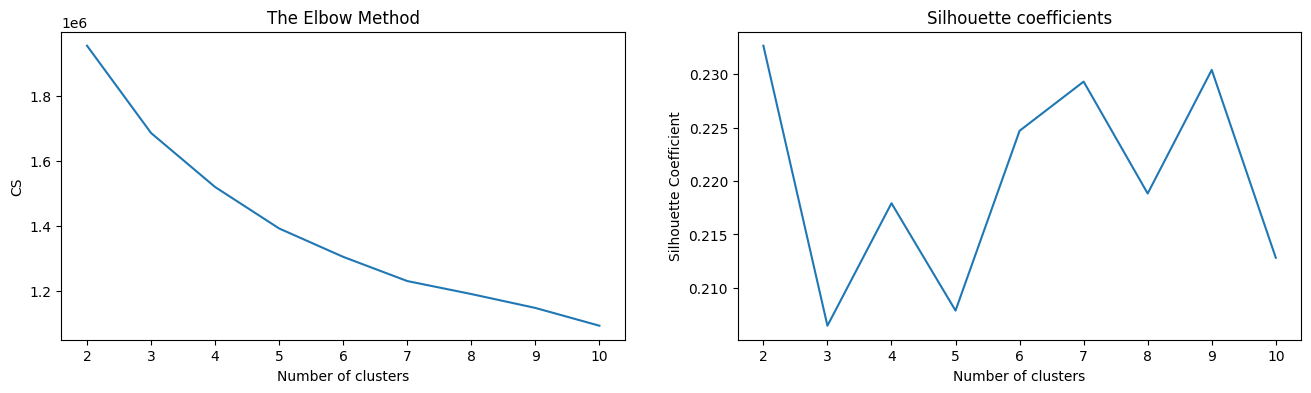

In [19]:
dfs = {}
all_features = {}

for folder in folders:
    ann_dir = os.path.join(base_dir, folder, ann_folder)
    filenames = sorted(glob.glob(ann_dir + '/*.xml'))
    print(folder, len(filenames))
    
    images = []
    lst = []
    for filename in tqdm(filenames):
        tree = ET.parse(filename)
        root = tree.getroot()
        objects = root.findall('object')
        if not objects:
            continue
        obj_count = len(objects)
        labels = []
#         widths = []
#         heights = []
        for member in objects:
            label = member.find('name').text
            labels.append(label)
        labels = sorted(list(set(labels)))
        lst.append([os.path.basename(filename).rsplit('.', maxsplit=1)[0], obj_count, labels])
        
        filename = filename.replace(ann_folder, img_folder).replace('.xml', f'.{img_ext}')
        image = cv2.imread(filename)
        if image is None:
            print(f'None: {filename}')
            continue
        image = cv2.resize(image, target_size)
        images.append(image)
    
    dfi = pd.DataFrame(lst, columns=['filename', 'count', 'labels'])
    dfi['labels_str'] = dfi['labels'].map(lambda x: '_'.join(x))
    dfs[folder] = dfi
    
    images = np.array(images)
    print('images', images.shape)
    
    features = []
    for image in tqdm(images):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        data = preprocess_input_vgg16(image)
        data = np.expand_dims(data, 0)
        feat = np.squeeze(model.predict(data, verbose=0))
        features.append(feat)

    features = np.array(features)
    print('features', features.shape)
    
    if pca_apply:
        pca = PCA(n_components=min(100, len(features)), random_state=42)
        pca.fit(features)
        top_features = pca.transform(features)
    else:
        top_features = features.copy()
    print('top_features', top_features.shape)
    all_features[folder] = top_features
    
    # Kmeans
    min_k = 2
    max_k = 10
    kmeans_kwargs = {
        "init": "random",  # k-means++
        "n_init": 10,
        "max_iter": 300,
        "random_state": 42,
    }

    cs = []
    silhouette_coefs = []
    
    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(top_features)

        # elbow
        cs.append(kmeans.inertia_)

        # silhouette
        sil_score = silhouette_score(top_features, kmeans.labels_)
        silhouette_coefs.append(sil_score)
          
        if draw_mean_images:
            # create mean image
            means = {}
            for cluster_id in kmeans.labels_:
                images_ids = np.where(np.array(kmeans.labels_) == cluster_id)[0]
                means[cluster_id] = {}
                means[cluster_id]['images'] = images[images_ids]
                means[cluster_id]['mean'] = np.mean(means[cluster_id]['images'], axis=(0))

            # draw mean images
            fig = plt.figure(figsize=(16, 16))
            for ix, cluster_id in enumerate(means.keys()):
                plt.subplot(1, k, ix + 1).set_title(f'Cluster {cluster_id}: {len(means[cluster_id]["images"])}')
                plt.imshow(means[cluster_id]['mean'] / 255.0)
                plt.axis('off')
            plt.show()
            fig.savefig(os.path.join(base_dir, folder, 'ImageSets', 'Main', f'cluster_{k}_mean_images.png'))

    # plot
    fig = plt.figure(figsize=(16, 4))
    plt.subplot(121).set_title('Elbow')
    plt.plot(range(min_k, max_k + 1), cs)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('CS')
    plt.subplot(122).set_title('Silhouette coefficients')
    plt.plot(range(min_k, max_k + 1), silhouette_coefs)
    plt.xticks(range(min_k, max_k + 1))
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    fig.savefig(os.path.join(base_dir, folder, 'ImageSets', 'Main', f'{cluster_name}.png'))

In [20]:
for ix, el in enumerate(top_features):
    if el is None:
        print(ix)

In [21]:
top_features.shape

(1022, 512)

## Iterative stratification

In [24]:
n_clusters_dict = {
    'pascal_voc_rosatom': 5
}
str_clusters = True
str_labels = True
str_count = False

test_shares = [10, 20, 30]

In [25]:
for folder in folders:
    
    n_clusters = n_clusters_dict[folder]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_features[folder])
    
    dfi = dfs[folder].copy()
    dfi[f'cluster_{n_clusters}'] = kmeans.labels_
    
    # clusters one hot encoding
    if str_clusters:
        df_clusters = pd.get_dummies(dfi[f'cluster_{n_clusters}'], prefix='cluster')
        dfi = pd.concat([dfi, df_clusters], axis=1)
    
    # count one hot encoding
    if str_clusters:
        df_count = pd.get_dummies(dfi['count'], prefix='count')
        dfi = pd.concat([dfi, df_count], axis=1)

    if str_labels:
        
        df_labels = pd.get_dummies(
            pd.DataFrame(dfi.labels.tolist(), dfi.index).stack()
        ).astype(int).groupby(level=0).sum()

        dfi = pd.concat([dfi, df_labels], axis=1)

    dfi.iloc[:, 5:] = dfi.iloc[:, 5:].astype(int)
    print(dfi.head())
    
    X = dfi.loc[:, 'filename'].to_numpy()
    y = dfi.iloc[:, 5:].to_numpy()
    
    for test_share in test_shares:
    
        stratifier = IterativeStratification(
            n_splits=2,
            order=2,
            sample_distribution_per_fold=[test_share / 100, 1 - test_share / 100],
        )
        train_indexes, everything_else_indexes = next(stratifier.split(X=X, y=y))

        num_overlapping_samples = len(set(train_indexes).intersection(set(everything_else_indexes)))
        if num_overlapping_samples != 0:
            raise ValueError(f'First splitting failed, {num_overlapping_samples} overlapping samples detected')
        
        train_txt = os.path.join(base_dir, folder, 'ImageSets', 'Main', f'iter_{sets_prefix}train_{100 - test_share}_{test_share}.txt')
        test_txt = os.path.join(base_dir, folder, 'ImageSets', 'Main', f'iter_{sets_prefix}test_{100 - test_share}_{test_share}.txt')
        
        if os.path.exists(train_txt):
            os.remove(train_txt)
        with open(train_txt, 'w') as f:
            pass
        
        for ix in train_indexes:
            with open(train_txt, 'a') as f:
                try:
                    f.write(dfi.loc[ix, 'filename'] + '\n')
                except:
                    print(filename)
        
        if os.path.exists(test_txt):
            os.remove(test_txt)
        with open(test_txt, 'w') as f:
            pass

        for ix in everything_else_indexes:
            with open(test_txt, 'a') as f:
                f.write(dfi.loc[ix, 'filename'] + '\n')


/var/folders/j3/htl_67j53z9dlhmz3d7mcs7c0000gn/T/ipykernel_9073/1330989949.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       0
3       0
4       0
       ..
1017    0
1018    0
1019    0
1020    0
1021    0
Name: cluster_0, Length: 1022, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dfi.iloc[:, 5:] = dfi.iloc[:, 5:].astype(int)
/var/folders/j3/htl_67j53z9dlhmz3d7mcs7c0000gn/T/ipykernel_9073/1330989949.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0
1       0
2       0
3       0
4       0
       ..
1017    0
1018    0
1019    0
1020    0
1021    0
Name: cluster_1, Length: 1022, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  dfi.iloc[:, 5:] = dfi.iloc[:, 5:].astype(int)
/var/folders/j3/htl_67

  filename  count labels labels_str  cluster_5  cluster_0  cluster_1  \
0   11_10_      1  [geo]        geo          2          0          0   
1   11_11_      1  [geo]        geo          2          0          0   
2   11_12_      1  [geo]        geo          2          0          0   
3   11_13_      1  [geo]        geo          2          0          0   
4   11_14_      1  [geo]        geo          2          0          0   

   cluster_2  cluster_3  cluster_4  ...  count_12  count_13  count_14  \
0          1          0          0  ...         0         0         0   
1          1          0          0  ...         0         0         0   
2          1          0          0  ...         0         0         0   
3          1          0          0  ...         0         0         0   
4          1          0          0  ...         0         0         0   

   count_15  count_19  adj  geo  int  non  pro  
0         0         0    0    1    0    0    0  
1         0         0    0    

In [26]:
!pwd

/Users/user/virtualenv/rosatom
